## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Dataset Overview

In [2]:
df = pd.read_csv("dataset.csv")
df.head()

,timestamp,hour_of_day,day_of_week,day_of_year,outside_temp,outside_humidity,weather_condition,occupancy_count,is_occupied,room_temp,power_kw,fan_speed,ac_temp_setting,ac_control_reason
0,2024-01-01 00:00:00,0,0,1,24.593342,60.000000,cloudy,0.0,0,26.006587,0.0,off,NaN,SYSTEM OFF: Room unoccupied
1,2024-01-01 00:05:00,0,0,1,24.661599,60.000000,rainy,0.0,0,26.037660,0.0,off,NaN,SYSTEM OFF: Room unoccupied
2,2024-01-01 00:10:00,0,0,1,24.612982,60.000000,cloudy,0.0,0,25.949107,0.0,off,NaN,SYSTEM OFF: Room unoccupied
3,2024-01-01 00:15:00,0,0,1,24.970486,65.615747,cloudy,0.0,0,25.933911,0.0,off,NaN,SYSTEM OFF: Room unoccupied
4,2024-01-01 00:20:00,0,0,1,24.346744,62.063288,cloudy,0.0,0,25.852349,0.0,off,NaN,SYSTEM OFF: Room unoccupied


In [3]:
df.describe()

,hour_of_day,day_of_week,day_of_year,outside_temp,outside_humidity,occupancy_count,is_occupied,room_temp,power_kw,ac_temp_setting
count,105121.000000,105121.000000,105121.000000,105121.000000,105121.000000,105121.000000,105121.000000,105121.000000,105121.000000,46119.000000
mean,11.499891,2.991762,183.001741,27.999405,75.823283,3.611885,0.449891,24.266641,0.696064,22.294109
std,6.922277,2.003414,105.367540,3.026859,12.949781,5.879752,0.497485,1.016505,0.786545,0.704029
min,0.000000,0.000000,1.000000,21.941441,60.000000,0.000000,0.000000,22.299940,0.000000,20.000000
25%,5.000000,1.000000,92.000000,25.432435,61.944477,0.000000,0.000000,23.490140,0.000000,22.000000
50%,11.000000,3.000000,183.000000,28.001006,75.003321,0.000000,0.000000,24.000350,0.000000,22.000000
75%,17.000000,5.000000,274.000000,30.565238,88.059324,5.000000,1.000000,24.809658,1.600000,23.000000
max,23.000000,6.000000,366.000000,34.087714,95.000000,20.000000,1.000000,29.858400,1.700000,23.000000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105121 entries, 0 to 105120
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   timestamp          105121 non-null  object 
 1   hour_of_day        105121 non-null  int64  
 2   day_of_week        105121 non-null  int64  
 3   day_of_year        105121 non-null  int64  
 4   outside_temp       105121 non-null  float64
 5   outside_humidity   105121 non-null  float64
 6   weather_condition  105121 non-null  object 
 7   occupancy_count    105121 non-null  float64
 8   is_occupied        105121 non-null  int64  
 9   room_temp          105121 non-null  float64
 10  power_kw           105121 non-null  float64
 11  fan_speed          105121 non-null  object 
 12  ac_temp_setting    46119 non-null   float64
 13  ac_control_reason  105121 non-null  object 
dtypes: float64(6), int64(4), object(4)
memory usage: 11.2+ MB


In [5]:
# Ensure the timestamp is in datetime format
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values('timestamp').reset_index(drop=True)

## Check for missing data

In [6]:
df.isna().sum()

timestamp                0
hour_of_day              0
day_of_week              0
day_of_year              0
outside_temp             0
outside_humidity         0
weather_condition        0
occupancy_count          0
is_occupied              0
room_temp                0
power_kw                 0
fan_speed                0
ac_temp_setting      59002
ac_control_reason        0
dtype: int64

Seems like teh NaN for ac_temp setting means that the ac temp power is turn off. Check if the fan still running when temp power turned off.

In [7]:
mask = df['ac_temp_setting'].isna() & (df['fan_speed'] != "off")
df_check = df[mask]

df_check.head()

,timestamp,hour_of_day,day_of_week,day_of_year,outside_temp,outside_humidity,weather_condition,occupancy_count,is_occupied,room_temp,power_kw,fan_speed,ac_temp_setting,ac_control_reason
1489,2024-01-06 04:05:00,4,5,6,24.714251,61.599213,cloudy,1.0,1,22.945861,0.05,low,NaN,"MAINTAIN: Temp in comfort zone, circulating air"
1490,2024-01-06 04:10:00,4,5,6,24.997882,60.000000,cloudy,1.0,1,23.036899,0.05,low,NaN,"MAINTAIN: Temp in comfort zone, circulating air"
1492,2024-01-06 04:20:00,4,5,6,24.625715,63.448664,cloudy,1.0,1,23.073706,0.05,low,NaN,"MAINTAIN: Temp in comfort zone, circulating air"
1494,2024-01-06 04:30:00,4,5,6,24.484208,60.000000,cloudy,1.0,1,23.014066,0.05,low,NaN,"MAINTAIN: Temp in comfort zone, circulating air"
1498,2024-01-06 04:50:00,4,5,6,24.327526,60.000000,rainy,1.0,1,22.860332,0.05,low,NaN,"MAINTAIN: Temp in comfort zone, circulating air"


Seems like sometime it is just the temp power is turned off, but the fan keep running to maintain the room temperature.

Now check what are the settings in ac_temp_setting

In [8]:
df['ac_temp_setting'].value_counts()

ac_temp_setting
22.0    25913
23.0    17992
20.0     2214
Name: count, dtype: int64

Can conclude NaN should also be learned by the model to turn off the compressor. 

## Visualization

### Count view

Numerical Data

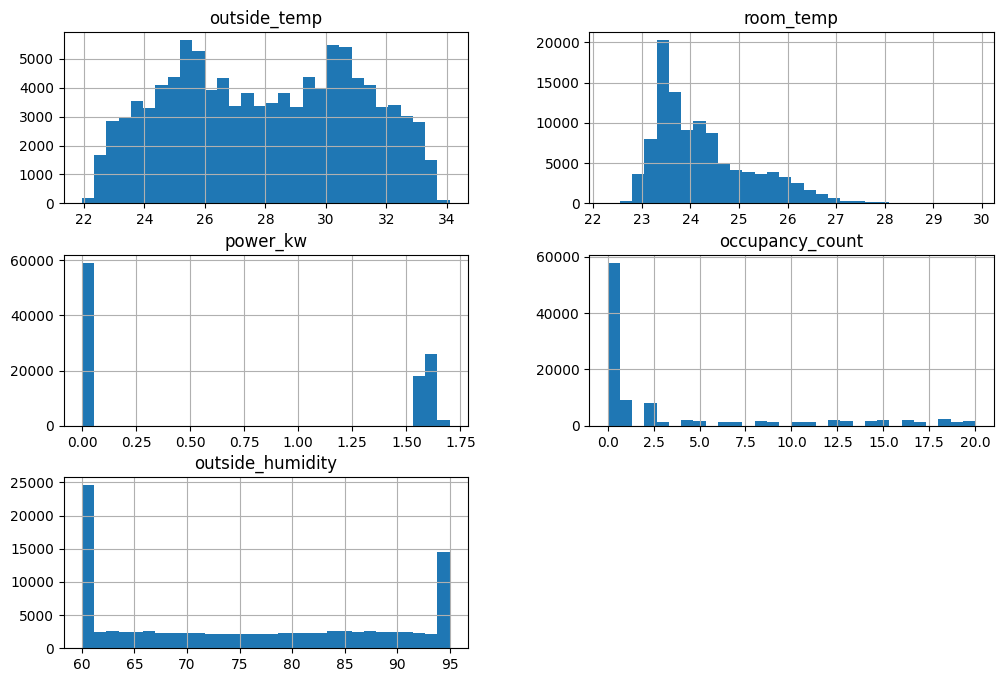

In [9]:
df[['outside_temp', 'room_temp', 'power_kw', 'occupancy_count', 'outside_humidity']].hist(bins=30, figsize=(12, 8))
plt.show()

Categorical data

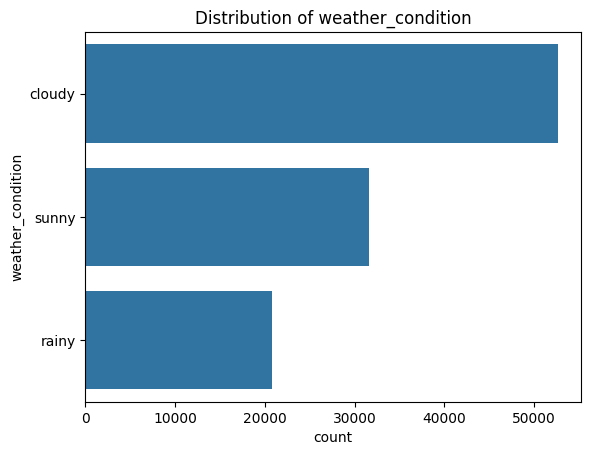

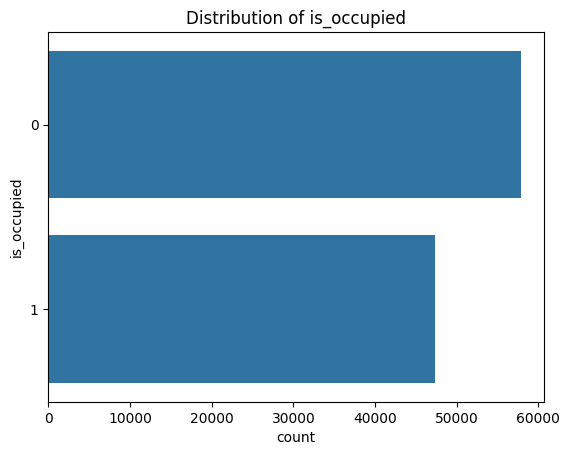

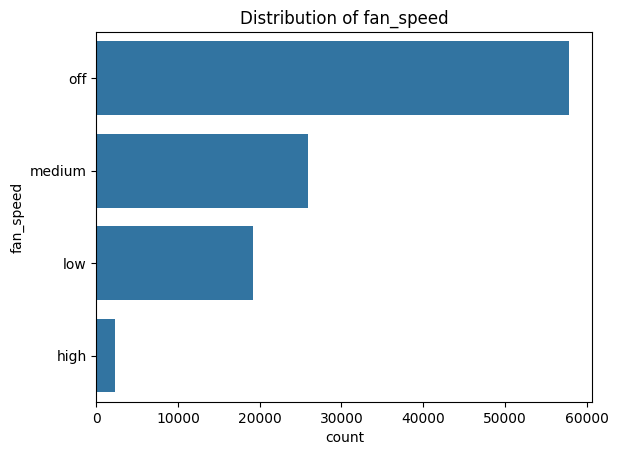

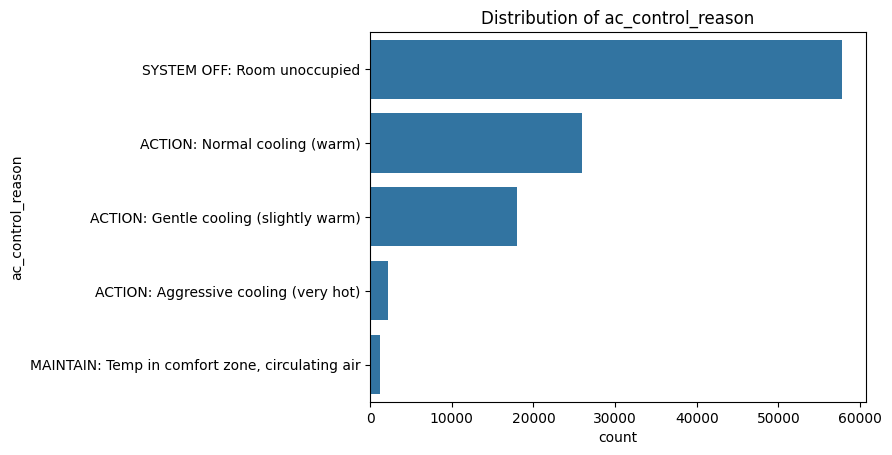

In [10]:
for col in ['weather_condition', 'is_occupied', 'fan_speed', 'ac_control_reason']:
    sns.countplot(y=df[col], order=df[col].value_counts().index)
    plt.title(f'Distribution of {col}')
    plt.show()

### Over timestamp view

In [11]:
# Down sample the data before plotting
df_resampled = df.resample("24H", on="timestamp").mean(numeric_only=True)

C:\Users\User\AppData\Local\Temp\ipykernel_24296\3175402751.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_resampled = df.resample("24H", on="timestamp").mean(numeric_only=True)


In [12]:
df_resampled.head()

,hour_of_day,day_of_week,day_of_year,outside_temp,outside_humidity,occupancy_count,is_occupied,room_temp,power_kw,ac_temp_setting
timestamp,,,,,,,,,,
2024-01-01,11.5,0.0,1.0,28.013302,75.728178,5.326389,0.572917,24.357221,0.907986,22.303030
2024-01-02,11.5,1.0,2.0,28.059901,76.031236,7.152778,0.496528,24.186098,0.796354,21.923077
2024-01-03,11.5,2.0,3.0,28.071094,75.638305,4.479167,0.350694,24.773321,0.561458,21.980198
2024-01-04,11.5,3.0,4.0,28.090166,76.314367,5.062500,0.461806,24.369677,0.735417,22.150376
2024-01-05,11.5,4.0,5.0,28.126216,76.059062,3.385417,0.368056,24.793840,0.584375,22.245283


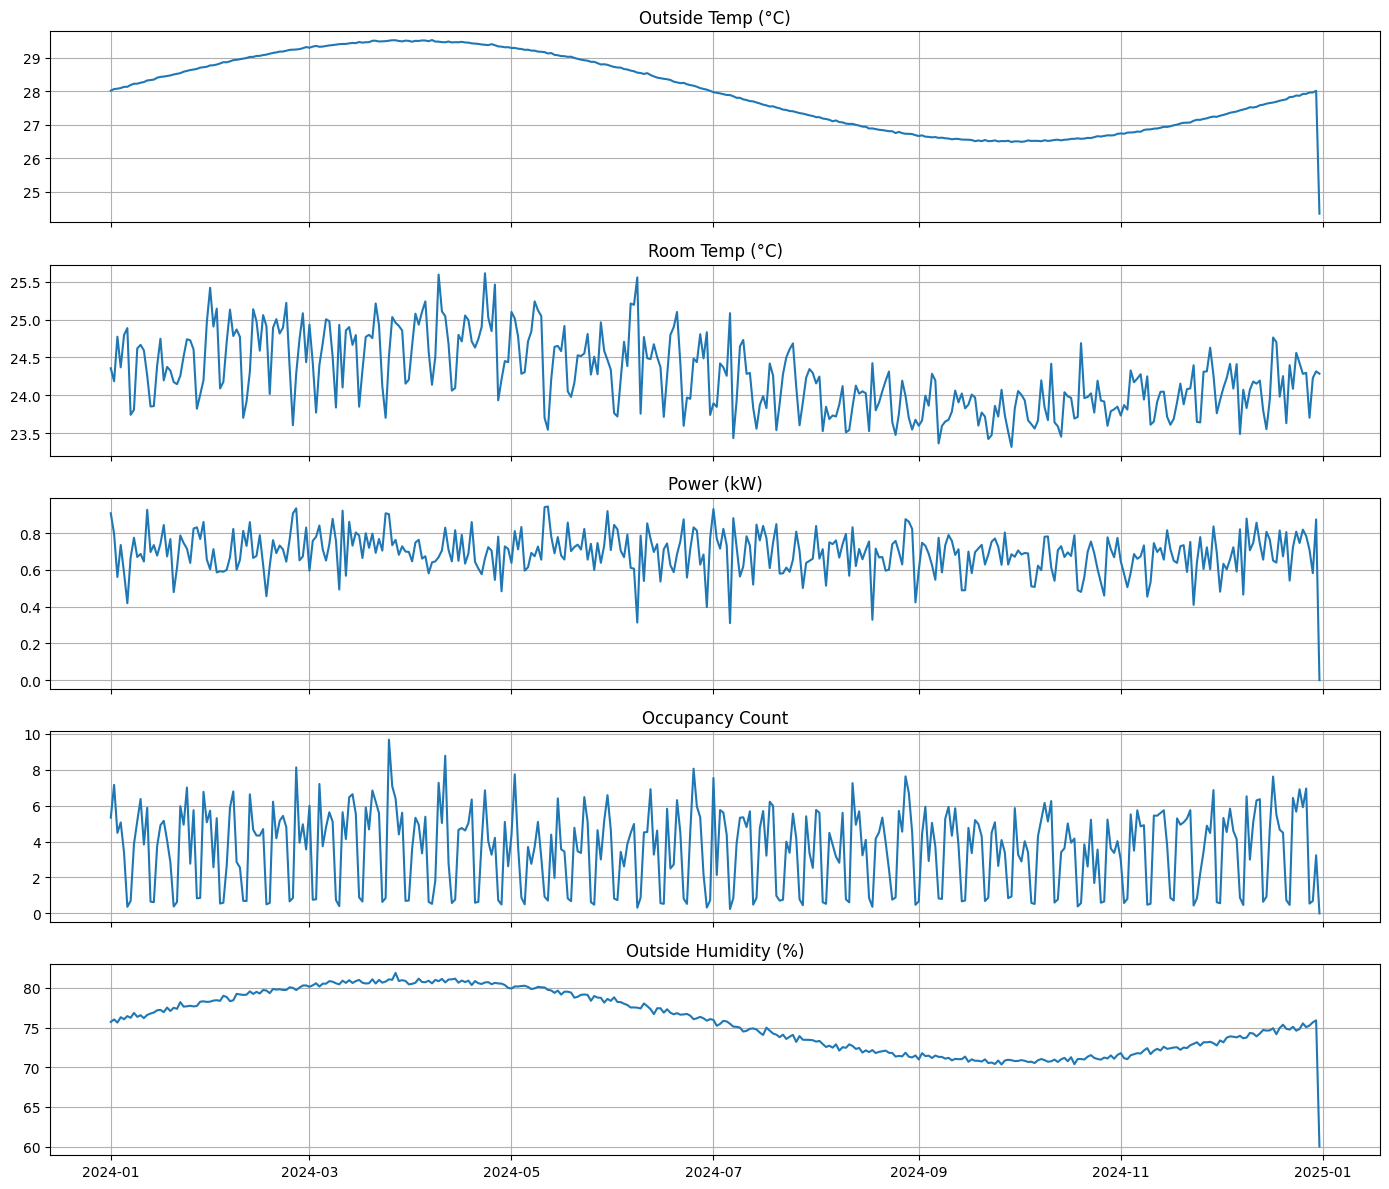

In [13]:
fig, axes = plt.subplots(5, 1, figsize=(14,12), sharex=True)

columns = ['outside_temp', 'room_temp', 'power_kw', 'occupancy_count', 'outside_humidity']
titles = ['Outside Temp (°C)', 'Room Temp (°C)', 'Power (kW)', 'Occupancy Count', 'Outside Humidity (%)']

for i, col in enumerate(columns):
    axes[i].plot(df_resampled.index, df_resampled[col])
    axes[i].set_title(titles[i])
    axes[i].grid(True)

plt.tight_layout()
plt.show()

### Room Temperature by Weather Condition and Power Usage by Occupancy

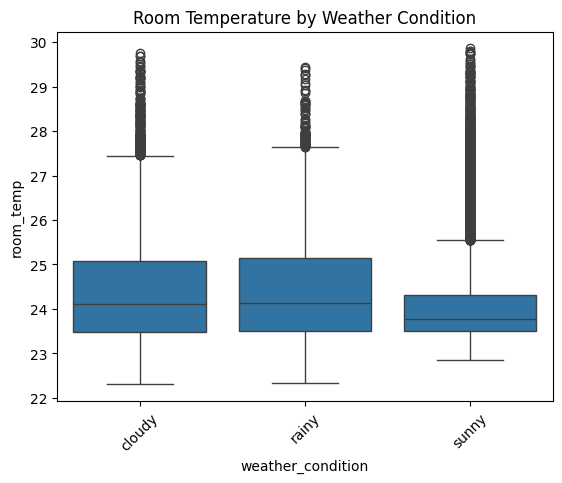

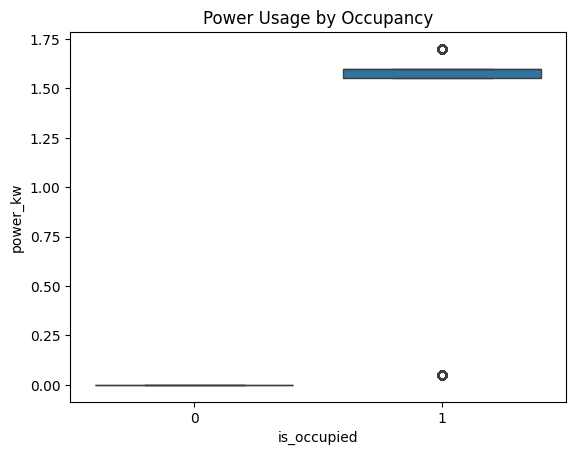

In [14]:
sns.boxplot(x='weather_condition', y='room_temp', data=df)
plt.xticks(rotation=45)
plt.title("Room Temperature by Weather Condition")
plt.show()

sns.boxplot(x='is_occupied', y='power_kw', data=df)
plt.title("Power Usage by Occupancy")
plt.show()

### Correlation Analysis

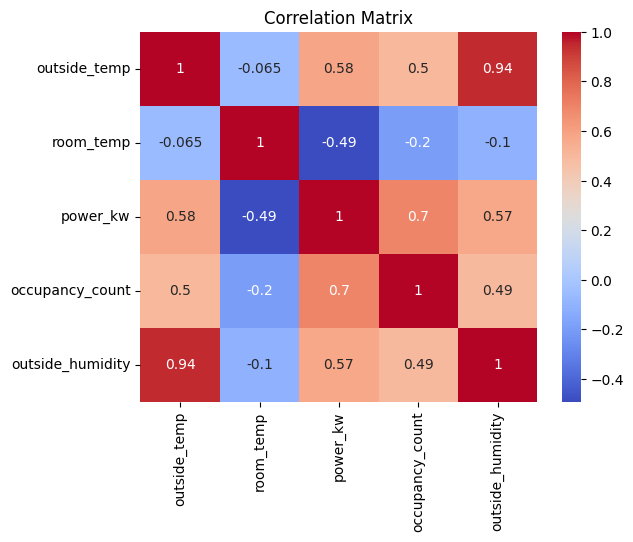

In [15]:
corr = df[['outside_temp', 'room_temp', 'power_kw', 'occupancy_count', 'outside_humidity']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

### Fan Speed by Occupancy

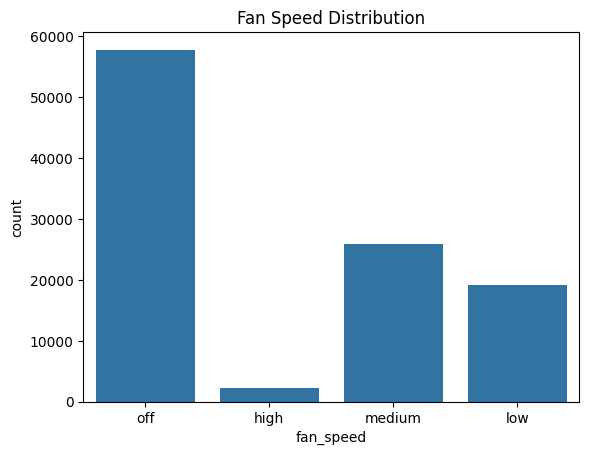

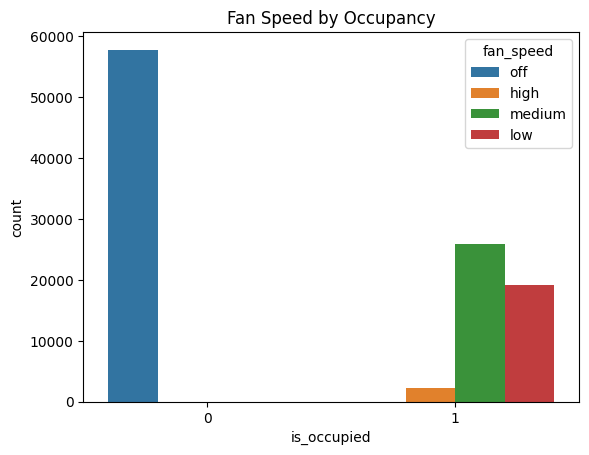

In [16]:
# Count of fan speeds
sns.countplot(x='fan_speed', data=df)
plt.title("Fan Speed Distribution")
plt.show()

# AC on/off by occupancy
sns.countplot(x='is_occupied', hue='fan_speed', data=df)
plt.title("Fan Speed by Occupancy")
plt.show()